In [4]:
import os
import glob
import numpy as np
import librosa
import gudhi  # For persistent homology and topological features
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data and create labels
normal_files = glob.glob('/home/evans/Downloads/Normal/*.wav')
wheezing_files = glob.glob('/home/evans/Downloads/Asthma/*.wav')
normal_labels = [0] * len(normal_files)
wheezing_labels = [1] * len(wheezing_files)
all_files = normal_files + wheezing_files
all_labels = normal_labels + wheezing_labels



# Print the number of normal and asthma samples
num_normal = all_labels.count(0)
num_asthma = all_labels.count(1)

print(f"Number of normal samples: {num_normal}")
print(f"Number of asthma samples: {num_asthma}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Feature extraction functions
def extract_mfcc_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.concatenate((np.mean(mfcc, axis=1), np.std(mfcc, axis=1)))

def extract_spectral_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    return [np.mean(spectral_centroids), np.mean(spectral_bandwidth)]

def extract_zero_crossing_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    return [np.mean(zero_crossing_rate)]

# Function to compute persistence diagram
def compute_persistence_diagram(signal):
    try:
        point_cloud = signal.reshape(-1, 1)
        rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=1.0)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()
        return persistence
    except Exception as e:
        return []

# Function to compute persistent entropy
def compute_persistent_entropy(signal):
    try:
        persistence = compute_persistence_diagram(signal)
        lifetimes = [p[1][1] - p[1][0] for p in persistence if p[1][1] != float('inf')]
        if len(lifetimes) > 0:
            entropy = -np.sum(np.log(lifetimes) * lifetimes)  # Example entropy computation
            return [entropy]
        else:
            return [0]  # If no persistence features found
    except Exception as e:
        return [0]

# Function to compute Carlsson coordinates
def compute_carlsson_coordinates(persistence, FN=5):
    try:
        persistence_points = np.array([(p[1][0], p[1][1]) for p in persistence if p[1][1] != float('inf')])
        if persistence_points.size == 0:
            return [0] * FN
        # Assuming Ff.F_CCoordinates exists to compute Carlsson coordinates
        FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(persistence_points, FN)
        return FeatureMatrix[-4]  # Return the feature vector
    except Exception as e:
        return [0] * FN

# Extract features
X_train_mfcc = np.array([extract_mfcc_features(file) for file in X_train])
X_test_mfcc = np.array([extract_mfcc_features(file) for file in X_test])

X_train_spectral = np.array([extract_spectral_features(file) for file in X_train])
X_test_spectral = np.array([extract_spectral_features(file) for file in X_test])

X_train_zero_crossing = np.array([extract_zero_crossing_features(file) for file in X_train])
X_test_zero_crossing = np.array([extract_zero_crossing_features(file) for file in X_test])

# Extract Persistent Entropy and Carlsson Coordinates
X_train_entropy = np.array([compute_persistent_entropy(file) for file in X_train])
X_test_entropy = np.array([compute_persistent_entropy(file) for file in X_test])

X_train_carlsson = np.array([compute_carlsson_coordinates(compute_persistence_diagram(file)) for file in X_train])
X_test_carlsson = np.array([compute_carlsson_coordinates(compute_persistence_diagram(file)) for file in X_test])

# Combine features
X_train_features = np.hstack((X_train_mfcc, X_train_spectral, X_train_zero_crossing, X_train_entropy, X_train_carlsson))
X_test_features = np.hstack((X_test_mfcc, X_test_spectral, X_test_zero_crossing, X_test_entropy, X_test_carlsson))

# Print the shape of the persistence diagram after adding Carlsson coordinates
print("Shape of Persistence Diagram + Carlsson Coordinates (Train):", X_train_carlsson.shape)
print("Shape of Persistence Diagram + Carlsson Coordinates (Test):", X_test_carlsson.shape)

# Train and evaluate model
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, random_state=42))
pipeline.fit(X_train_features, y_train)
y_pred = pipeline.predict(X_test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Cross-validation
cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


Number of normal samples: 105
Number of asthma samples: 96
Shape of Persistence Diagram + Carlsson Coordinates (Train): (160, 5)
Shape of Persistence Diagram + Carlsson Coordinates (Test): (41, 5)
Accuracy: 0.7317073170731707
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.74      0.70      0.72        20

    accuracy                           0.73        41
   macro avg       0.73      0.73      0.73        41
weighted avg       0.73      0.73      0.73        41

Confusion Matrix:
[[16  5]
 [ 6 14]]
Cross-validation scores: [0.65625 0.625   0.625   0.625   0.8125 ]
Mean CV score: 0.66875


Number of normal samples: 105
Number of asthma samples: 96


/home/evans/.local/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature Importance Ranking:
Feature 21: 0.0765
Feature 22: 0.0640
Feature 24: 0.0540
Feature 20: 0.0460
Feature 25: 0.0447
Feature 40: 0.0376
Feature 23: 0.0357
Feature 14: 0.0319
Feature 29: 0.0313
Feature 8: 0.0305


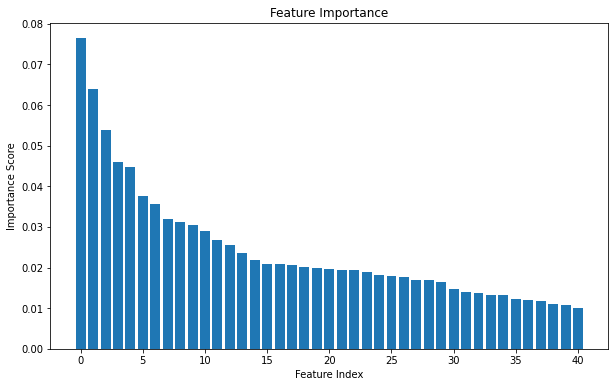


Accuracy after RFE:
Accuracy: 0.8292682926829268
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.88      0.75      0.81        20

    accuracy                           0.83        41
   macro avg       0.84      0.83      0.83        41
weighted avg       0.84      0.83      0.83        41


Accuracy after PCA:
Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        21
           1       0.67      0.60      0.63        20

    accuracy                           0.66        41
   macro avg       0.66      0.66      0.66        41
weighted avg       0.66      0.66      0.66        41


Cross-validation scores: [0.71875 0.59375 0.59375 0.5625  0.8125 ]
Mean CV score: 0.65625

Confusion Matrix:
[[19  2]
 [ 5 15]]


In [5]:
import os
import glob
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load data and create labels
normal_files = glob.glob('/home/evans/Downloads/Normal/*.wav')
wheezing_files = glob.glob('/home/evans/Downloads/Asthma/*.wav')
normal_labels = [0] * len(normal_files)
wheezing_labels = [1] * len(wheezing_files)
all_files = normal_files + wheezing_files
all_labels = normal_labels + wheezing_labels

# Print the number of normal and asthma samples
num_normal = all_labels.count(0)
num_asthma = all_labels.count(1)
print(f"Number of normal samples: {num_normal}")
print(f"Number of asthma samples: {num_asthma}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Feature extraction functions
def extract_mfcc_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.concatenate((np.mean(mfcc, axis=1), np.std(mfcc, axis=1)))

def extract_spectral_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    return [np.mean(spectral_centroids), np.mean(spectral_bandwidth), np.mean(spectral_rolloff)]

def extract_chroma_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    return np.mean(chroma_stft, axis=1)

# Extract features
def extract_features(file_paths):
    features = []
    for file_path in file_paths:
        try:
            mfcc_features = extract_mfcc_features(file_path)
            spectral_features = extract_spectral_features(file_path)
            chroma_features = extract_chroma_features(file_path)
            combined_features = np.concatenate([mfcc_features, spectral_features, chroma_features])
            features.append(combined_features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            features.append(np.zeros(40))  # Handle errors with a default vector
    return np.array(features)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

# Feature Selection: Feature Importance from Random Forest
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=200, random_state=24))
pipeline.fit(X_train_features, y_train)

# Feature Importance
rf_model = pipeline.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 10 important features
print("Feature Importance Ranking:")
for idx in indices[:10]:
    print(f"Feature {idx}: {importances[idx]:.4f}")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20, step=1)
rfe.fit(X_train_features, y_train)

# Features selected by RFE
selected_features = rfe.support_
X_train_selected = X_train_features[:, selected_features]
X_test_selected = X_test_features[:, selected_features]

# Retrain model with selected features
pipeline.fit(X_train_selected, y_train)
y_pred_selected = pipeline.predict(X_test_selected)

print("\nAccuracy after RFE:")
print("Accuracy:", accuracy_score(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))

# Dimensionality Reduction with PCA
pca = PCA(n_components=10)  # Retain top 10 components
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Train with PCA-transformed features
pipeline.fit(X_train_pca, y_train)
y_pred_pca = pipeline.predict(X_test_pca)

print("\nAccuracy after PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))

# Cross-validation with final model
cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_selected)
print("\nConfusion Matrix:")
print(cm)
